In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation.
import PIL.Image
from IPython.display import display
#from resizeimage import resizeimage

#Panda
import pandas as pd

#Open a Zip File
from zipfile import ZipFile
from io import BytesIO

#check tensorflow version
tf.__version__

'1.8.0'

In [3]:
def DataBase_creator(archivezip, nwigth, nheight, save_name):
    #We choose the archive (zip file) + the new wigth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwigth, nheight,3) #nwigth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwigth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [4]:
archive_train = ZipFile("/home/koushik/Downloads/train.zip", 'r')

#This line shows the 5 first image name of the train database
archive_train.namelist()[0:5]

#This line shows the number of images in the train database
len(archive_train.namelist()[:])-1 #we must remove the 1st value

10222

In [5]:
image_resize = 40

In [6]:
DataBase_creator(archivezip = archive_train, nwigth = image_resize, nheight = image_resize , save_name = "train")

Time usage: 0:02:45


In [7]:
train = pickle.load( open( "train.p", "rb" ) )
train.shape

(10222, 40, 40, 3)

In [9]:
labels_raw = pd.read_csv("/home/koushik/Downloads/labels.csv.zip", compression='zip', header=0, sep=',', quotechar='"')

#Check 5 random values
labels_raw.sample(5)

,id,breed
4649,7453c0ad6556fbbc5443a046855bdd22,irish_setter
5406,88664fc7a27b5828860ef5bae18b5309,italian_greyhound
8778,dc07c140b26ba8f2c75770f00229270b,japanese_spaniel
7221,b4f8d8eff4f0b4d93b8416a87daa3b93,newfoundland
923,16a760e466fd2b2fe0ef8879b5b2245d,groenendael


In [10]:
Nber_of_breeds = 120

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 120 main breeds : (10222,)
- The shape of train_filtered dataset is : (10222, 40, 40, 3)


In [11]:
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(10222, 1)

In [12]:
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [13]:
labels_name, labels_bin = matrix_Bin(labels)

Nber SubVariables 120
Shape : (10222, 120)


In [14]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)
X_train.shape

(7155, 40, 40, 3)

In [15]:
df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([ 16,  39,   5,  89,  77, 113,  68,  15,  23])

In [16]:
img_size = image_resize

num_channels = 3

img_size_flat = img_size * img_size

img_shape = (img_size, img_size, num_channels)

num_classes = Nber_of_breeds

In [17]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [18]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,     
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases

    
    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    return layer, weights

In [19]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [20]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [21]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [22]:
filter_size1 = 4          
num_filters1 = 32       

filter_size2 = 2          
num_filters2 = 64      

filter_size3 = 2          
num_filters3 = 128      
fc_size = 500 

In [23]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

In [24]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

<tf.Tensor 'dropout_1/mul:0' shape=(?, 500) dtype=float32>

In [26]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 120) dtype=float32>

In [27]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [30]:
session = tf.Session()

def init_variables():
    session.run(tf.global_variables_initializer())

In [31]:
batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [32]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    end_time = time.time()

    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [33]:
init_variables()
total_iterations = 0

In [34]:
optimize(num_iterations=3000, X=250)

Iteration:    250, Training Accuracy:   0.0%, Validation Accuracy:   0.7%
Iteration:    500, Training Accuracy:   0.0%, Validation Accuracy:   1.1%
Iteration:    750, Training Accuracy:   2.0%, Validation Accuracy:   1.1%
Iteration:   1000, Training Accuracy:   2.0%, Validation Accuracy:   1.3%


KeyboardInterrupt: 

Iteration:   3050, Training Accuracy:   0.0%, Validation Accuracy:   2.4%
Iteration:   3100, Training Accuracy:   0.0%, Validation Accuracy:   2.4%
Iteration:   3150, Training Accuracy:   4.0%, Validation Accuracy:   2.6%
Iteration:   3200, Training Accuracy:   0.0%, Validation Accuracy:   2.4%
Iteration:   3250, Training Accuracy:   2.0%, Validation Accuracy:   2.4%
Iteration:   3300, Training Accuracy:   6.0%, Validation Accuracy:   2.6%
Iteration:   3350, Training Accuracy:   4.0%, Validation Accuracy:   3.1%
Iteration:   3400, Training Accuracy:   4.0%, Validation Accuracy:   2.8%
Iteration:   3450, Training Accuracy:   2.0%, Validation Accuracy:   3.0%
Iteration:   3500, Training Accuracy:   0.0%, Validation Accuracy:   2.7%
Iteration:   3550, Training Accuracy:   4.0%, Validation Accuracy:   3.0%
Iteration:   3600, Training Accuracy:   0.0%, Validation Accuracy:   2.8%
Iteration:   3650, Training Accuracy:   0.0%, Validation Accuracy:   2.8%
Iteration:   3700, Training Accuracy: 

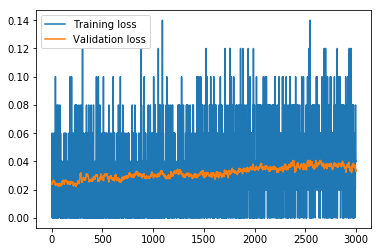

In [42]:
optimize(num_iterations=3000, X=50)

#### My image size is very low i.e 20 x 20 as i couldnt takke a better size as my system was hanging.

Iteration:   6050, Training Accuracy:   4.0%, Validation Accuracy:   3.6%
Iteration:   6100, Training Accuracy:   6.0%, Validation Accuracy:   3.7%
Iteration:   6150, Training Accuracy:  12.0%, Validation Accuracy:   3.5%
Iteration:   6200, Training Accuracy:   2.0%, Validation Accuracy:   3.9%
Iteration:   6250, Training Accuracy:   4.0%, Validation Accuracy:   3.7%
Iteration:   6300, Training Accuracy:   2.0%, Validation Accuracy:   3.8%
Iteration:   6350, Training Accuracy:   4.0%, Validation Accuracy:   4.0%
Iteration:   6400, Training Accuracy:   4.0%, Validation Accuracy:   3.9%
Iteration:   6450, Training Accuracy:   4.0%, Validation Accuracy:   3.9%
Iteration:   6500, Training Accuracy:   2.0%, Validation Accuracy:   3.9%
Iteration:   6550, Training Accuracy:   6.0%, Validation Accuracy:   4.0%
Iteration:   6600, Training Accuracy:   2.0%, Validation Accuracy:   3.7%
Iteration:   6650, Training Accuracy:   4.0%, Validation Accuracy:   4.1%
Iteration:   6700, Training Accuracy: 

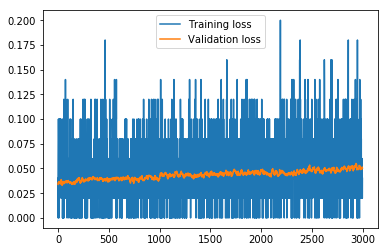

In [43]:
optimize(num_iterations=3000, X=50)

Iteration:   9050, Training Accuracy:   4.0%, Validation Accuracy:   4.9%
Iteration:   9100, Training Accuracy:   4.0%, Validation Accuracy:   5.1%
Iteration:   9150, Training Accuracy:  14.0%, Validation Accuracy:   5.2%
Iteration:   9200, Training Accuracy:   4.0%, Validation Accuracy:   5.3%
Iteration:   9250, Training Accuracy:   2.0%, Validation Accuracy:   5.4%
Iteration:   9300, Training Accuracy:   0.0%, Validation Accuracy:   5.7%
Iteration:   9350, Training Accuracy:  14.0%, Validation Accuracy:   5.2%
Iteration:   9400, Training Accuracy:   4.0%, Validation Accuracy:   5.2%
Iteration:   9450, Training Accuracy:   6.0%, Validation Accuracy:   5.3%
Iteration:   9500, Training Accuracy:   2.0%, Validation Accuracy:   5.0%
Iteration:   9550, Training Accuracy:   6.0%, Validation Accuracy:   5.1%
Iteration:   9600, Training Accuracy:   6.0%, Validation Accuracy:   5.0%
Iteration:   9650, Training Accuracy:  12.0%, Validation Accuracy:   5.3%
Iteration:   9700, Training Accuracy: 

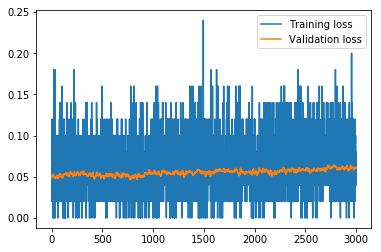

In [44]:
optimize(num_iterations=3000, X=50)

Iteration:  12050, Training Accuracy:   4.0%, Validation Accuracy:   6.1%
Iteration:  12100, Training Accuracy:   6.0%, Validation Accuracy:   5.6%
Iteration:  12150, Training Accuracy:   2.0%, Validation Accuracy:   6.1%
Iteration:  12200, Training Accuracy:  12.0%, Validation Accuracy:   5.8%
Iteration:  12250, Training Accuracy:   4.0%, Validation Accuracy:   6.2%
Iteration:  12300, Training Accuracy:   8.0%, Validation Accuracy:   6.3%
Iteration:  12350, Training Accuracy:   6.0%, Validation Accuracy:   6.0%
Iteration:  12400, Training Accuracy:   2.0%, Validation Accuracy:   6.1%
Iteration:  12450, Training Accuracy:  12.0%, Validation Accuracy:   6.1%
Iteration:  12500, Training Accuracy:   6.0%, Validation Accuracy:   5.8%
Iteration:  12550, Training Accuracy:  10.0%, Validation Accuracy:   6.2%
Iteration:  12600, Training Accuracy:   4.0%, Validation Accuracy:   6.1%
Iteration:  12650, Training Accuracy:   6.0%, Validation Accuracy:   6.4%
Iteration:  12700, Training Accuracy: 

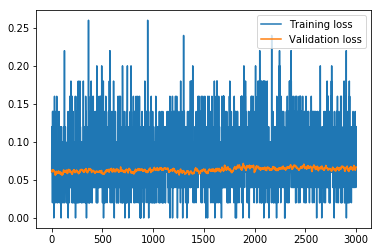

In [45]:
optimize(num_iterations=3000, X=50)

In [51]:
batch_size=100

Iteration:  15050, Training Accuracy:   5.0%, Validation Accuracy:   6.6%
Iteration:  15100, Training Accuracy:   8.0%, Validation Accuracy:   6.4%
Iteration:  15150, Training Accuracy:  10.0%, Validation Accuracy:   6.6%
Iteration:  15200, Training Accuracy:  11.0%, Validation Accuracy:   6.7%
Iteration:  15250, Training Accuracy:   8.0%, Validation Accuracy:   6.7%
Iteration:  15300, Training Accuracy:   7.0%, Validation Accuracy:   6.8%
Iteration:  15350, Training Accuracy:   9.0%, Validation Accuracy:   6.7%
Iteration:  15400, Training Accuracy:   8.0%, Validation Accuracy:   6.7%
Iteration:  15450, Training Accuracy:   7.0%, Validation Accuracy:   6.7%
Iteration:  15500, Training Accuracy:   5.0%, Validation Accuracy:   7.0%
Iteration:  15550, Training Accuracy:  12.0%, Validation Accuracy:   6.8%
Iteration:  15600, Training Accuracy:  11.0%, Validation Accuracy:   6.7%
Iteration:  15650, Training Accuracy:   9.0%, Validation Accuracy:   6.8%
Iteration:  15700, Training Accuracy: 

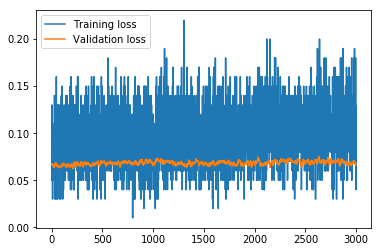

In [52]:
optimize(num_iterations=3000, X=50)

Iteration:  18050, Training Accuracy:  10.0%, Validation Accuracy:   6.7%
Iteration:  18100, Training Accuracy:  12.0%, Validation Accuracy:   7.2%
Iteration:  18150, Training Accuracy:  13.0%, Validation Accuracy:   6.7%
Iteration:  18200, Training Accuracy:  11.0%, Validation Accuracy:   6.8%
Iteration:  18250, Training Accuracy:   9.0%, Validation Accuracy:   7.0%
Iteration:  18300, Training Accuracy:   9.0%, Validation Accuracy:   7.1%
Iteration:  18350, Training Accuracy:  11.0%, Validation Accuracy:   6.8%
Iteration:  18400, Training Accuracy:   9.0%, Validation Accuracy:   7.5%
Iteration:  18450, Training Accuracy:  13.0%, Validation Accuracy:   7.0%
Iteration:  18500, Training Accuracy:  13.0%, Validation Accuracy:   7.1%
Iteration:  18550, Training Accuracy:  13.0%, Validation Accuracy:   7.3%
Iteration:  18600, Training Accuracy:   5.0%, Validation Accuracy:   7.1%
Iteration:  18650, Training Accuracy:  13.0%, Validation Accuracy:   7.1%
Iteration:  18700, Training Accuracy: 

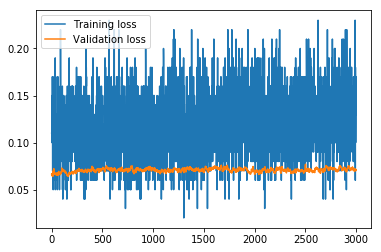

In [53]:
optimize(num_iterations=3000, X=50)